From https://towardsdatascience.com/audio-classification-with-pytorchs-ecosystem-tools-5de2b66e640c

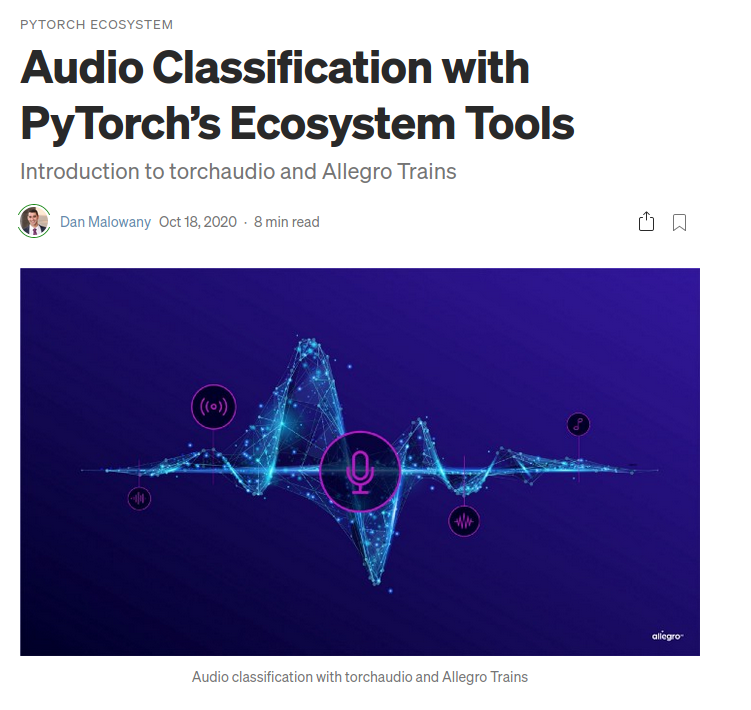

 # Audio Classification with Convolutional Neural Networks

## Preprocessing: Audio Classification with Convolutional Neural Networks

> The following preprocessing was done using [this script](http://t.allegro.ai/code_pytorch_audioclassification) on the [YesNo](https://pytorch.org/audio/datasets.html#yesno) dataset that is included in [torchaudio built-in datasets](https://pytorch.org/audio/datasets.html).



* Read the audio file — using torchaudio
* Resample the audio signal to a fixed sample rate — This will make sure that all signals we will use will have the same sample rate. Theoretically, the maximum frequency that can be represented by a sampled signal is a little bit less than half the sample rate (known as the Nyquist frequency). As 20 kHz is the highest frequency generally audible by humans, sampling rate of 44100 Hz is considered the most popular choice. However, in many cases removing the higher frequencies is considered plausible for the sake of reducing the amount of data per audio file. As such, the sampling rate of 20050 Hz has been reasonably popular for low bitrate MP3 files. In our example we will use this sample rate.
* Create a mono audio signal — For simplicity, we will make sure all signals we use will have the same number of channels.

### from audio_preprocessing_example.ipynb

In [69]:
import os
import torch
import torchaudio
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from clearml import Task

%matplotlib inline

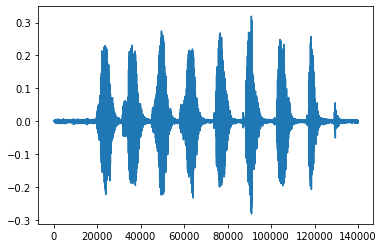

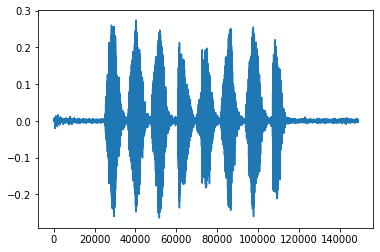

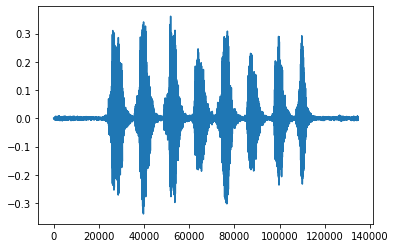

In [9]:
yesno_data = torchaudio.datasets.YESNO('./data', download=False)
number_of_samples = 3
fixed_sample_rate = 22050

for n in range(number_of_samples):
    audio, sample_rate, labels = yesno_data[n]    
    resample_transform = torchaudio.transforms.Resample(
        orig_freq=sample_rate, new_freq=fixed_sample_rate)    
    audio_mono = torch.mean(resample_transform(audio),
                            dim=0, keepdim=True)

    plt.figure()
    plt.plot(audio_mono[0,:])

In [13]:
task = Task.init(project_name='Audio Example', task_name='data pre-processing')
configuration_dict = {'number_of_samples': 3}
configuration_dict = task.connect(configuration_dict)  # enabling configuration override by clearml
print(configuration_dict)  # printing actual configuration (after override in remote mode)


ClearML Task: created new task id=594baba0ecc24dbb85430789f240d597
2021-04-21 17:53:59,208 - clearml.Repository Detection - WARNING - Can't get branch information for git repo in /home/explore/git/guillaume/zoe
2021-04-21 17:53:59,217 - clearml.Repository Detection - WARNING - Can't get commit information for git repo in /home/explore/git/guillaume/zoe
ClearML results page: https://demoapp.demo.clear.ml/projects/73a551bc9c0243c688b5ed98d47e5abb/experiments/594baba0ecc24dbb85430789f240d597/output/log
{'number_of_samples': 3}
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [14]:
tensorboard_writer = SummaryWriter('./tensorboard_logs')

In [15]:
if not os.path.isdir('./data'):
    os.mkdir('./data')
yesno_data = torchaudio.datasets.YESNO('./data', download=False)


In [16]:
def plot_signal(signal, title, cmap=None):
    plt.figure()
    if signal.ndim == 1:
        plt.plot(signal)
    else:
        plt.imshow(signal, cmap=cmap)    
    plt.title(title)
    plt.show()

/home/explore/miniconda3/envs/zoe/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.



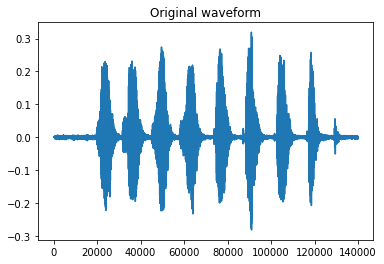

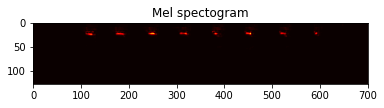

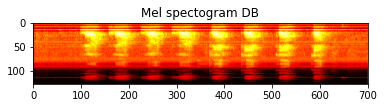

/home/explore/miniconda3/envs/zoe/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.



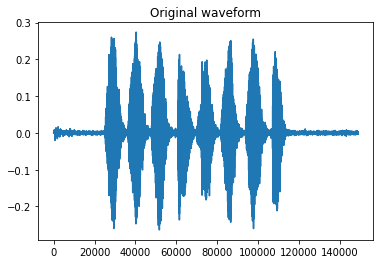

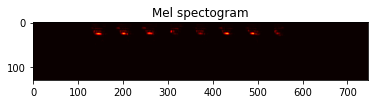

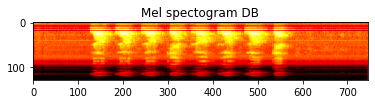

/home/explore/miniconda3/envs/zoe/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.



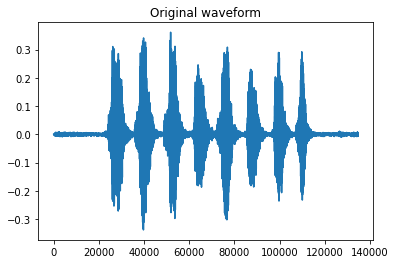

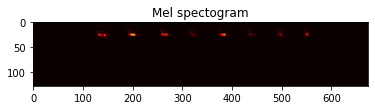

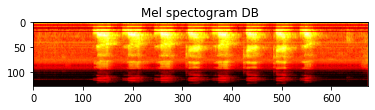

In [17]:
fixed_sample_rate = 22050
for n in range(configuration_dict.get('number_of_samples', 3)):
    audio, sample_rate, labels = yesno_data[n]
    tensorboard_writer.add_audio('Audio samples/{}'.format(n), audio, n, sample_rate)
    
    resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=fixed_sample_rate)
    melspectogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate=fixed_sample_rate, n_mels=128)
    
    audio_mono = torch.mean(resample_transform(audio), dim=0, keepdim=True)
    plot_signal(audio_mono[0,:], 'Original waveform')
    
    melspectogram = melspectogram_transform(audio_mono)
    plot_signal(melspectogram.squeeze().numpy(), 'Mel spectogram', 'hot')
    plot_signal(torchaudio.transforms.AmplitudeToDB()(melspectogram).squeeze().numpy(), 'Mel spectogram DB', 'hot')


### from https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

In [70]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
    matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)


def _fetch_data():
    uri = [
        (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
        (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
        (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
        (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
        (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
        (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
    ]
    for url, path in uri:
        with open(path, 'wb') as file_:
            file_.write(requests.get(url).content)


_fetch_data()


def _download_yesno():
    if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
        return
    torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)


YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()


def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.append(["rate", f'{resample}'])
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)


def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)


def get_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)


def get_rir_sample(*, resample=None, processed=False):
    rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
    if not processed:
        return rir_raw, sample_rate
    rir = rir_raw[:, int(sample_rate * 1.01):int(sample_rate * 1.3)]
    rir = rir / torch.norm(rir, p=2)
    rir = torch.flip(rir, [1])
    return rir, sample_rate


def get_noise_sample(*, resample=None):
    return _get_sample(SAMPLE_NOISE_PATH, resample=resample)


def print_metadata(metadata, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    print(" - sample_rate:", metadata.sample_rate)
    print(" - num_channels:", metadata.num_channels)
    print(" - num_frames:", metadata.num_frames)
    print(" - bits_per_sample:", metadata.bits_per_sample)
    print(" - encoding:", metadata.encoding)
    print()


def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()


def plot_waveform(waveform,
                  sample_rate,
                  title="Waveform",
                  xlim=None,
                  ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError(
            "Waveform with more than 2 channels are not supported.")


def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print_metadata(torchaudio.info(path))


def plot_spectrogram(spec,
                     title=None,
                     ylabel='freq_bin',
                     aspect='auto',
                     xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_mel_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Filter bank')
    axs.imshow(fbank, aspect='auto')
    axs.set_ylabel('frequency bin')
    axs.set_xlabel('mel bin')
    plt.show(block=False)


def get_spectrogram(
    n_fft=400,
    win_len=None,
    hop_len=None,
    power=2.0,
):
    waveform, _ = get_speech_sample()
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(waveform)


def plot_pitch(waveform, sample_rate, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln2 = axis2.plot(time_axis,
                     pitch[0],
                     linewidth=2,
                     label='Pitch',
                     color='green')

    axis2.legend(loc=0)
    plt.show(block=False)


def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Kaldi Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln1 = axis.plot(time_axis,
                    pitch[0],
                    linewidth=2,
                    label='Pitch',
                    color='green')
    axis.set_ylim((-1.3, 1.3))

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, nfcc.shape[1])
    ln2 = axis2.plot(time_axis,
                     nfcc[0],
                     linewidth=2,
                     label='NFCC',
                     color='blue',
                     linestyle='--')

    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    axis.legend(lns, labels, loc=0)
    plt.show(block=False)

In [23]:
SAMPLE_MP3_PATH='data/numbers/0.mp3'
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print_metadata(metadata, src=SAMPLE_MP3_PATH)


----------
Source: data/numbers/0.mp3
----------
 - sample_rate: 44100
 - num_channels: 2
 - num_frames: 82908
 - bits_per_sample: 0
 - encoding: MP3



Sample Rate: 44100
Shape: (2, 82908)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -1.000
 - Mean:     0.093
 - Std Dev:  0.323

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0032, -0.0012,  0.0073],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0025, -0.0030,  0.0003]])



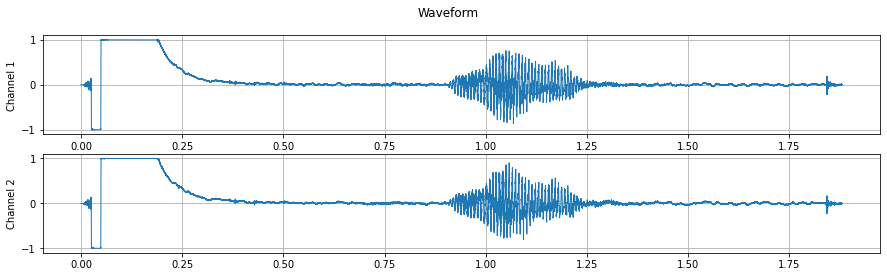

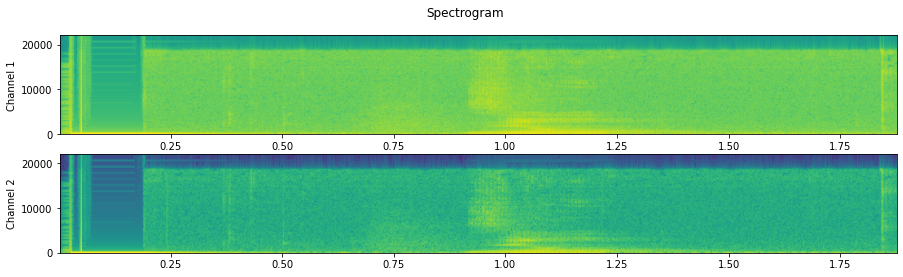

In [24]:
waveform, sample_rate = torchaudio.load(SAMPLE_MP3_PATH)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

data/numbers/0.mp3


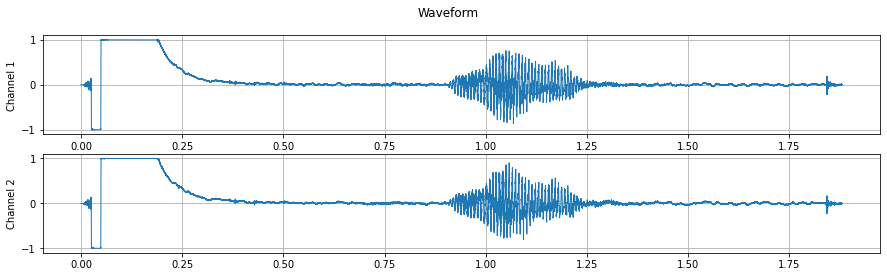

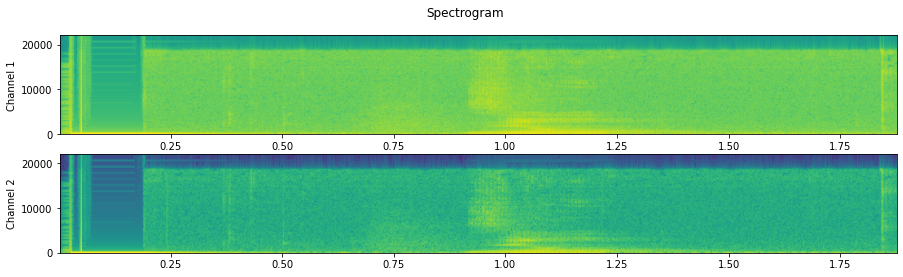

data/numbers/1.mp3


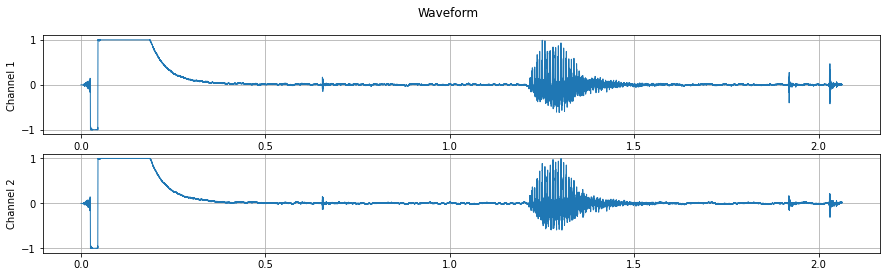

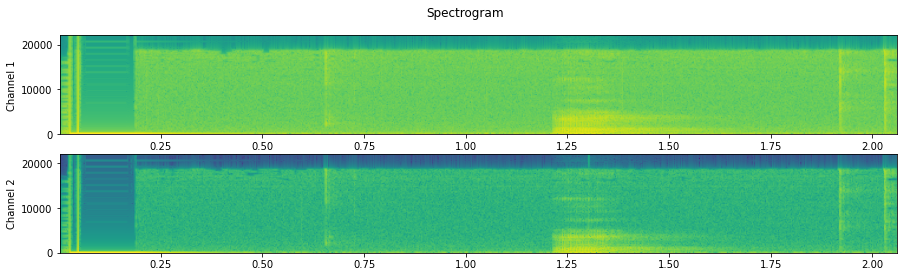

data/numbers/10.mp3


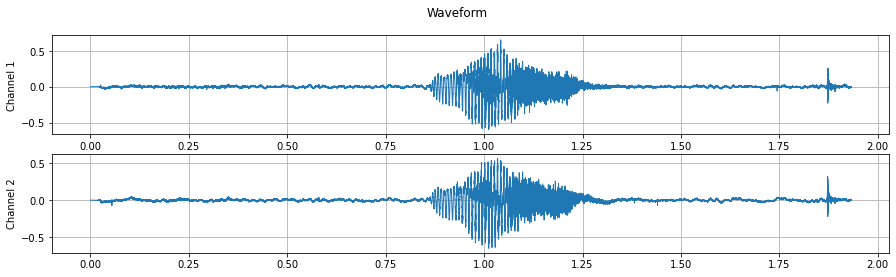

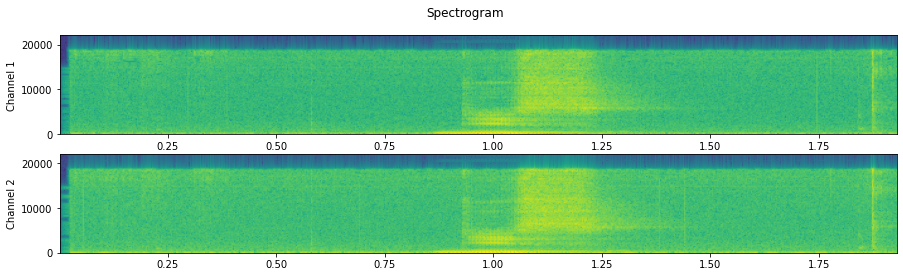

data/numbers/4.mp3


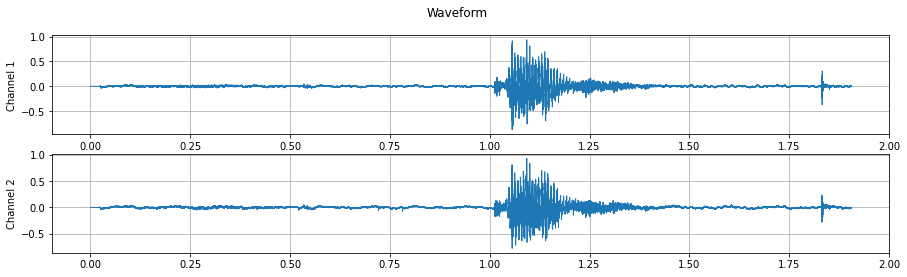

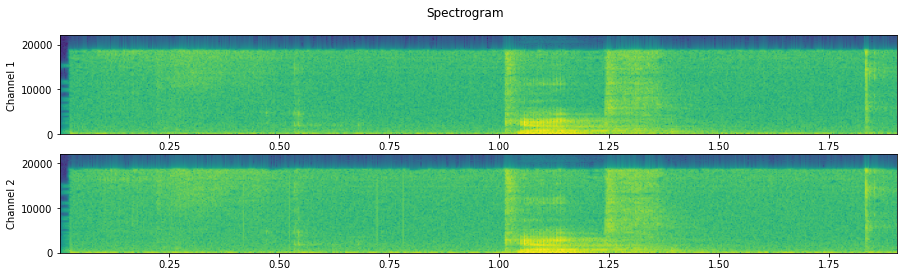

data/numbers/9.mp3


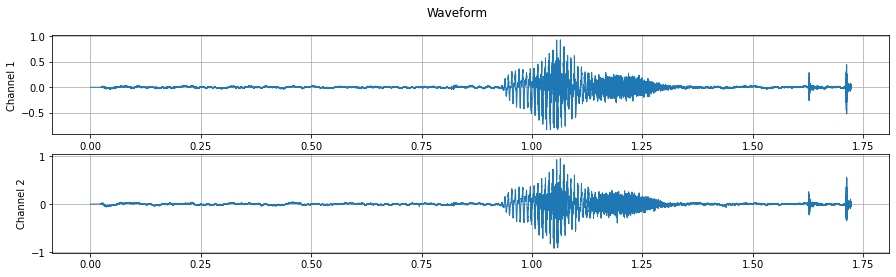

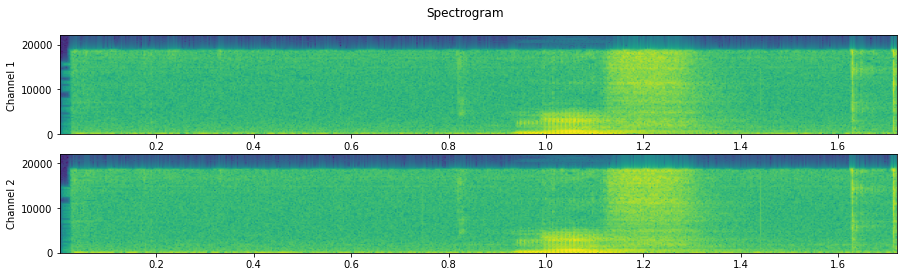

data/numbers/6.mp3


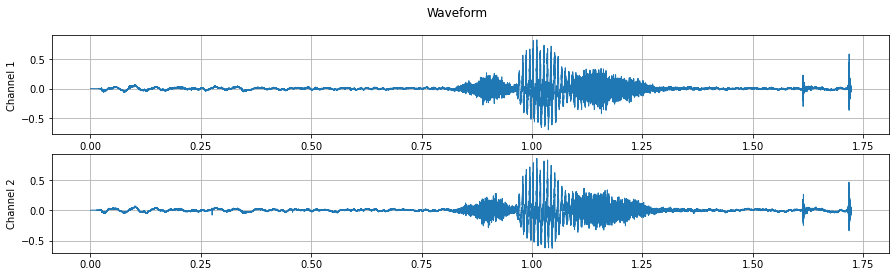

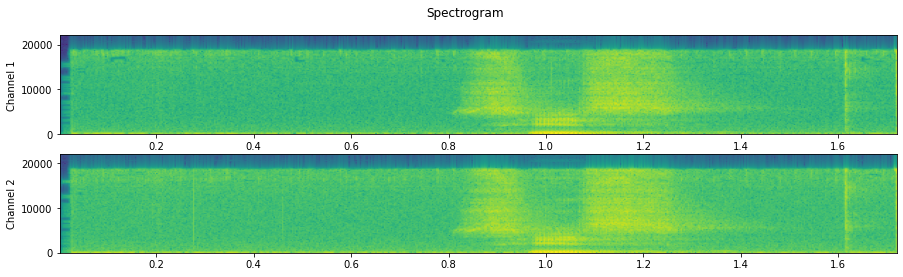

data/numbers/2.mp3


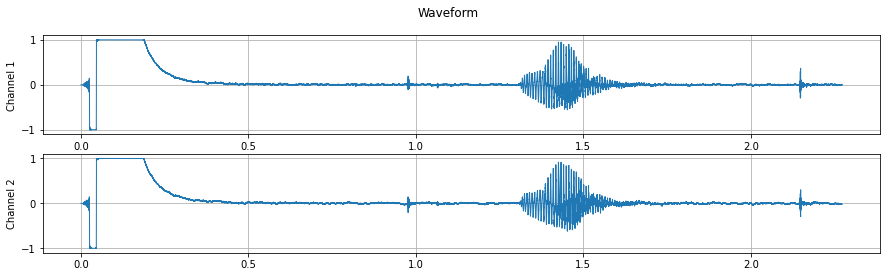

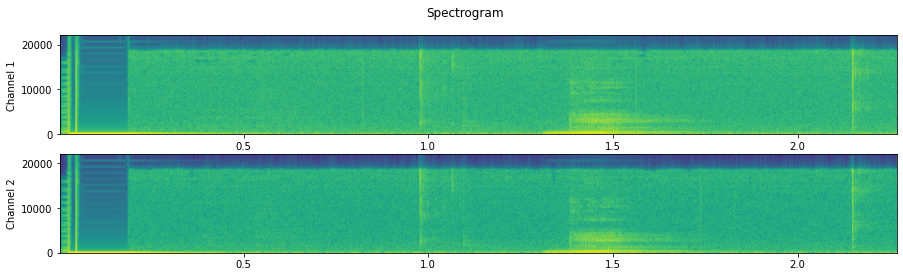

data/numbers/8.mp3


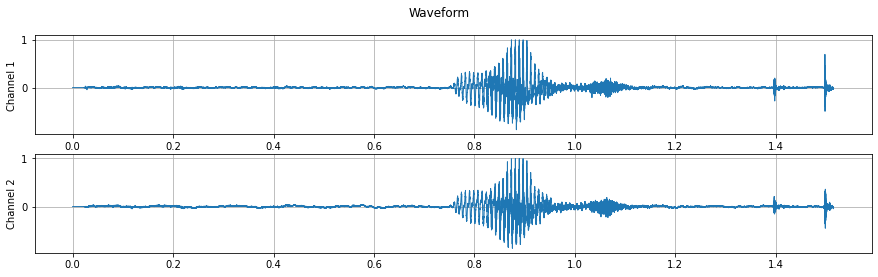

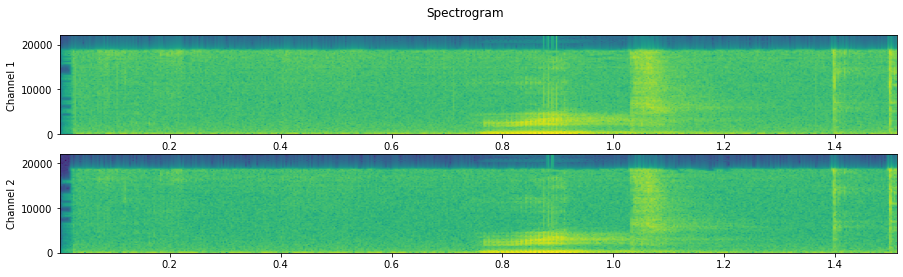

data/numbers/7.mp3


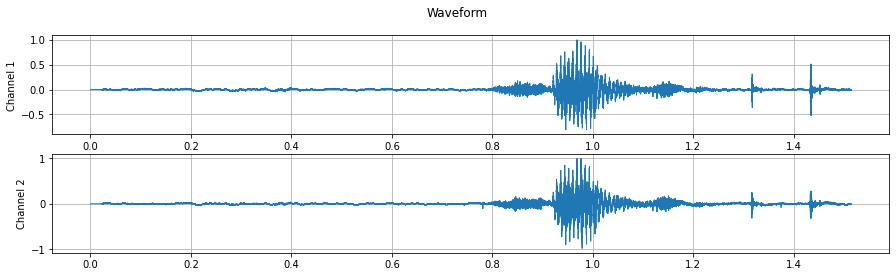

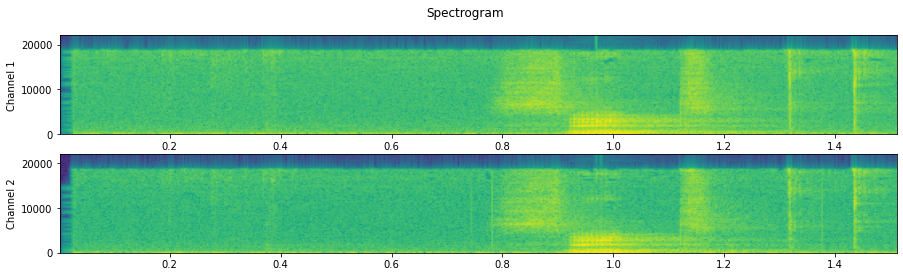

data/numbers/5.mp3


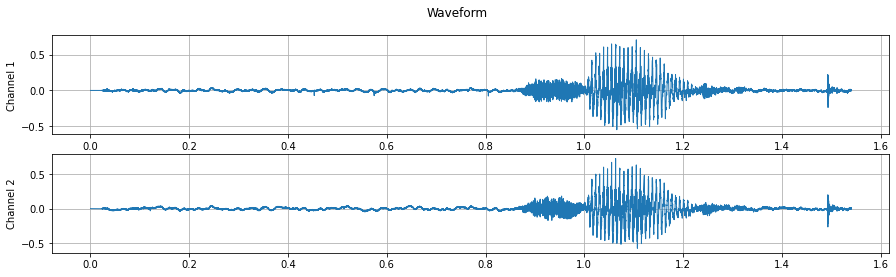

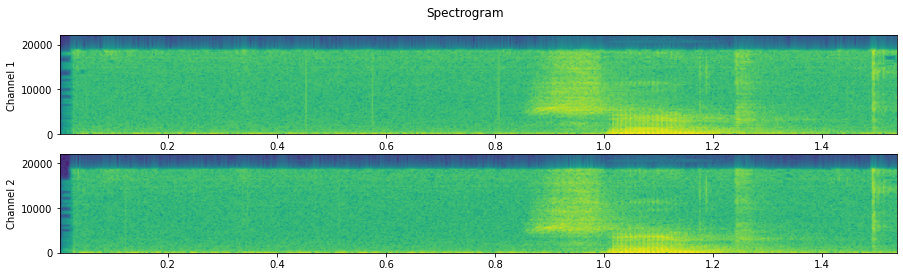

data/numbers/3.mp3


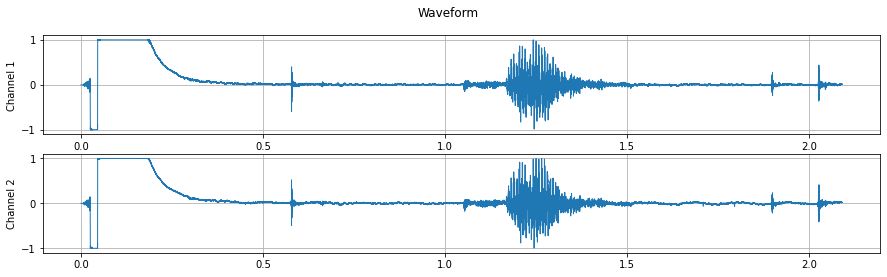

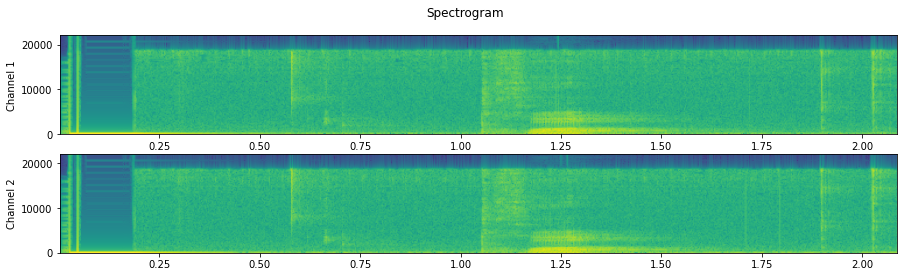

In [35]:
import glob
for file_name in glob.iglob('data/numbers/*.mp3', recursive=True):
    print(file_name)
    waveform, sample_rate = torchaudio.load(file_name)
    plot_waveform(waveform, sample_rate)

    plot_specgram(waveform, sample_rate)

    

### back to audio classification article

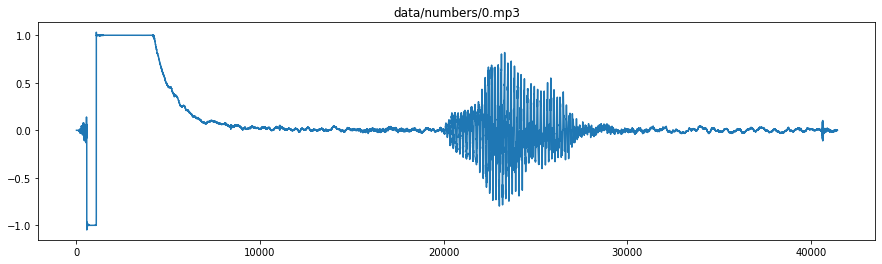

/home/explore/miniconda3/envs/zoe/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.



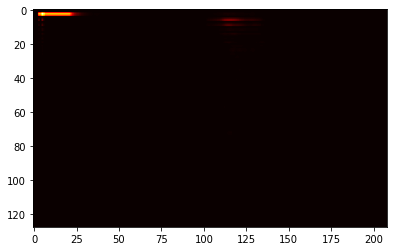

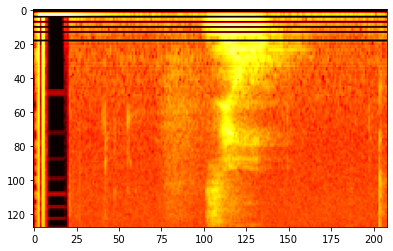

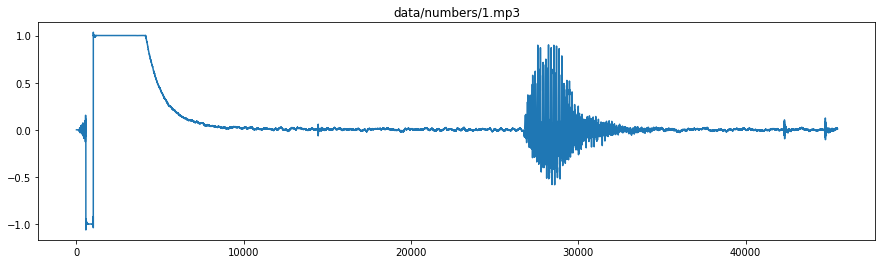

/home/explore/miniconda3/envs/zoe/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.



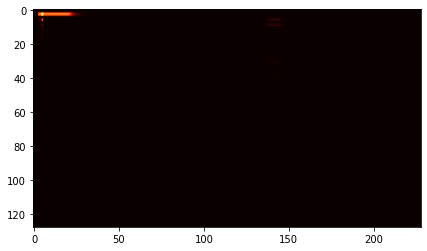

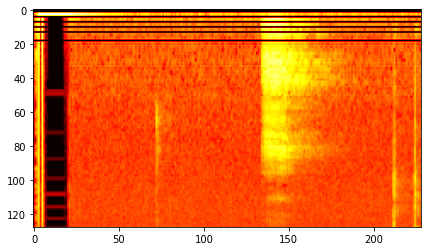

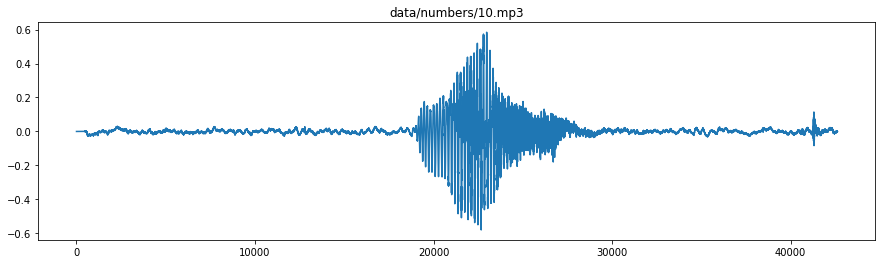

/home/explore/miniconda3/envs/zoe/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.



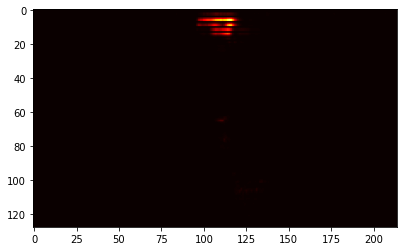

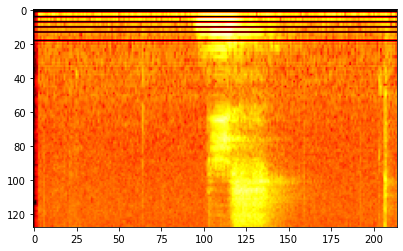

In [58]:
import itertools

fixed_sample_rate = 22050

for mp3_file in itertools.islice(glob.iglob('data/numbers/*.mp3', recursive=True), 3):
    audio, sample_rate = torchaudio.load(mp3_file)
    resample_transform = torchaudio.transforms.Resample(
        orig_freq=sample_rate, new_freq=fixed_sample_rate)    
    audio_mono = torch.mean(resample_transform(audio),
                            dim=0, keepdim=True)

    plt.figure()
    plt.plot(audio_mono[0,:])  
    plt.title(mp3_file)
    plt.show()
    
    melspectogram_transform = torchaudio.transforms.MelSpectrogram(sample_rate=fixed_sample_rate, n_mels=128)
    melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()

    melspectogram = melspectogram_transform(audio_mono)
    plt.figure()
    plt.imshow(melspectogram.squeeze().numpy(), cmap='hot')

    melspectogram_db=melspectogram_db_transform(melspectogram)
    plt.figure()
    plt.imshow(melspectogram_db.squeeze().numpy(), cmap='hot')
    plt.show()

## Using Allegro-Trains, torchaudio and torchvision for audio classification

> -   [Allegro Trains](https://allegro.ai/trains-open-source/?utm_source=pytorch_blog&utm_medium=referral&utm_campaign=trains_c&utm_content=audioclass) is an open-source machine learning and deep learning experiment manager and MLOps solution. It boosts the effectiveness and productivity of AI teams as well as on-prem and cloud GPU utilization. Allegro Trains helps researchers and developers to manage complex machine learning projects with zero integration effort.
> -   [Torchaudio](https://pytorch.org/audio/) is a package consisting of I/O function, popular datasets and common audio transformations.
> -   [Torchvision](https://pytorch.org/docs/stable/torchvision/index.html) is a package consisting of popular datasets, model architectures, and common image transformations for computer vision.

Creation of clear-ml (legacy trains) at https://app.community.clear.ml/dashboard?signup=

### We will start by initializing Allegro Trains to track everything we do:

In [3]:
from clearml import Task
# task.close()
task = Task.init(project_name="zoe", task_name="classification de nombres - task")
configuration_dict = {'number_of_epochs': 10, 'batch_size': 1, 'dropout': 0.25, 'base_lr': 0.001}
configuration_dict = task.connect(configuration_dict)

### dataset object

In [4]:
import PIL
import io

import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

import torchaudio
from torchvision.transforms import ToTensor

from clearml import Task

%matplotlib inline

In [29]:
class KM_SoundDataset(Dataset):
    def __init__(self, csv_path, file_path, folderList, resample_freq=0, return_audio=False):
        self.file_path = file_path
        self.file_names = []
        self.labels = []
        self.folders = []
        self.n_mels = configuration_dict.get('number_of_mel_filters', 64)
        self.return_audio = return_audio
        self.resample = resample_freq
        
        #loop through the csv files and only add those from the folder list
        csvData = pd.read_csv(csv_path)
        for i in range(0,len(csvData)):
            if csvData.iloc[i, 1] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i, 2])
                self.folders.append(csvData.iloc[i, 1])
        
    def __getitem__(self, index):
        #format the file path and load the file
#         path = self.file_path / ("fold" + str(self.folders[index])) / self.file_names[index]
        path = self.file_names[index]
        sound, sample_rate = torchaudio.load(path, out = None, normalization = True)

        if self.resample > 0:
            resample_transform = torchaudio.transforms.Resample(
              orig_freq=sample_rate, new_freq=self.resample)
            soundData = resample_transform(soundData)

        # This will convert audio files with two channels into one
        soundData = torch.mean(soundData, dim=0, keepdim=True)

        # Convert audio to log-scale Mel spectrogram
        melspectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.resample, n_mels=self.n_mels)
        melspectrogram = melspectrogram_transform(soundData)
        melspectogram_db = torchaudio.transforms.AmplitudeToDB()(melspectrogram)

        #Make sure all spectrograms are the same size
        fixed_length = 3 * (self.resample//200)
        if melspectogram_db.shape[2] < fixed_length:
            melspectogram_db = torch.nn.functional.pad(
              melspectogram_db, (0, fixed_length - melspectogram_db.shape[2]))
        else:
            melspectogram_db = melspectogram_db[:, :, :fixed_length]

        return soundData, self.resample, melspectogram_db, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)
                

In [30]:
import glob
from pathlib import Path

def create_metadata_file(folder):
    index_file=0
    dict_metadata_mp3 = {}
    for mp3_file in glob.iglob(folder+'/*.mp3', recursive=True):
        dict_metadata_mp3[index_file]=[mp3_file, Path(mp3_file).stem, Path(mp3_file).stem, Path(mp3_file).stem]
        index_file+=1
    pd_metadata_mp3 = pd.DataFrame.from_dict(dict_metadata_mp3, orient='index', columns=['slice_file_name', 'fold', 'classID', 'class'])
    audio_folder = Path(folder)
    metadata_folder = audio_folder.parent / 'metadata'
    pd_metadata_mp3.to_csv(str(metadata_folder)+'/numbers.csv')
        
create_metadata_file('data/numbers/audio')  

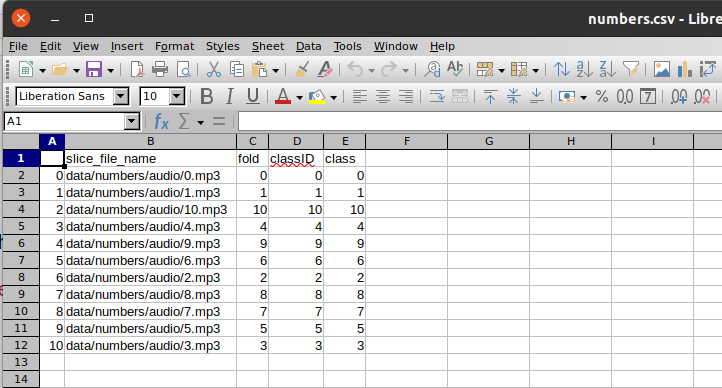

In [31]:

path_to_SoundDataset_csv = Path('data') / 'numbers' / 'metadata' / 'numbers.csv'
path_to_SoundDataset_audio = Path('data') / 'numbers' /  'audio'

In [34]:
train_set = KM_SoundDataset(path_to_SoundDataset_csv, path_to_SoundDataset_audio, range(1,5), 
                              resample_freq=configuration_dict.get('resample_freq', 0), return_audio=False)
test_set = KM_SoundDataset(path_to_SoundDataset_csv, path_to_SoundDataset_audio, [5], 
                             resample_freq=configuration_dict.get('resample_freq', 0), return_audio=True)
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

train_loader = torch.utils.data.DataLoader(train_set, batch_size = configuration_dict.get('batch_size', 4), 
                                           shuffle = True, pin_memory=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = configuration_dict.get('batch_size', 4), 
                                          shuffle = False, pin_memory=False, num_workers=1)

classes = (0,1,2,3,4,5,6,7,8,9,10)


Train set size: 0
Test set size: 0


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [10]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                      kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], 
                      padding=model.conv1.padding[0])
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

In [11]:
optimizer = optim.SGD(model.parameters(), lr = configuration_dict.get('base_lr', 0.001), momentum = 0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = configuration_dict.get('number_of_epochs')//3, gamma = 0.1)
criterion = nn.CrossEntropyLoss()


In [12]:
device = torch.cuda.current_device() if torch.cuda.is_available() else torch.device('cpu')
print('Device to use: {}'.format(device))
model.to(device)


Device to use: 0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [13]:
tensorboard_writer = SummaryWriter('./tensorboard_logs')

In [14]:
def plot_signal(signal, title, cmap=None):
    fig = plt.figure()
    if signal.ndim == 1:
        plt.plot(signal)
    else:
        plt.imshow(signal, cmap=cmap)    
    plt.title(title)
    
    plot_buf = io.BytesIO()
    plt.savefig(plot_buf, format='jpeg')
    plot_buf.seek(0)
    plt.close(fig)
    return ToTensor()(PIL.Image.open(plot_buf))

In [15]:
def train(model, epoch):
    model.train()
    for batch_idx, (sounds, sample_rate, inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        iteration = epoch * len(train_loader) + batch_idx
        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(inputs), len(train_loader.dataset), 
                          100. * batch_idx / len(train_loader), loss))
            tensorboard_writer.add_scalar('training loss/loss', loss, iteration)
            tensorboard_writer.add_scalar('learning rate/lr', optimizer.param_groups[0]['lr'], iteration)
                
        
        if batch_idx % debug_interval == 0:    # report debug image every "debug_interval" mini-batches
            for n, (inp, pred, label) in enumerate(zip(inputs, predicted, labels)):
                series = 'label_{}_pred_{}'.format(classes[label.cpu()], classes[pred.cpu()])
                tensorboard_writer.add_image('Train MelSpectrogram samples/{}_{}_{}'.format(batch_idx, n, series), 
                                             plot_signal(inp.cpu().numpy().squeeze(), series, 'hot'), iteration)

In [16]:
def test(model, epoch):
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for idx, (sounds, sample_rate, inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels)
            for i in range(len(inputs)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1
        
            iteration = (epoch + 1) * len(train_loader)
            if idx % debug_interval == 0:    # report debug image every "debug_interval" mini-batches
                for n, (sound, inp, pred, label) in enumerate(zip(sounds, inputs, predicted, labels)):
                    series = 'label_{}_pred_{}'.format(classes[label.cpu()], classes[pred.cpu()])
                    tensorboard_writer.add_audio('Test audio samples/{}_{}_{}'.format(idx, n, series), 
                                                 sound, iteration, int(sample_rate[n]))
                    tensorboard_writer.add_image('Test MelSpectrogram samples/{}_{}_{}'.format(idx, n, series), 
                                                 plot_signal(inp.cpu().numpy().squeeze(), series, 'hot'), iteration)

    total_accuracy = 100 * sum(class_correct)/sum(class_total)
    print('[Iteration {}] Accuracy on the {} test images: {}%\n'.format(epoch, sum(class_total), total_accuracy))
    tensorboard_writer.add_scalar('accuracy/total', total_accuracy, iteration)

In [17]:
log_interval = 10
debug_interval = 25
for epoch in range(configuration_dict.get('number_of_epochs', 10)):
    train(model, epoch)
    test(model, epoch)
    scheduler.step()

NameError: name 'train_loader' is not defined